In [1]:
# Install new dependencies
import sys
!{sys.executable} -m pip install opencv-python

In [2]:
# Import all the dependencies

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import numpy as np
import pickle
import ipywidgets as widgets
from scipy.stats import norm
import time

import sys
import os
sys.path.insert(0, os.path.abspath('Support'))

from Robot import *
from Measurements import *
from Renderer import *
from Distribution import *
from Helper import *

# Model Uncertainty: Why?

Recall our PenguinPi model kinematic model from lecture 2

<img src="Support/images/PenguinPi_Model.png" width="300" height="300" align="center">

Let's see how well this model predicts the real robot motion. To do so, we will apply control inputs to the real robot and measure the resulting state. We will then apply the same control inputs into our motion model and observe whether there is a difference between the observed (red curve) and predicted robot states (blue curve).

**Note**: The real data was generated by applying varying left and right wheel inputs to the PenguinPi and measuring where the robot ended up with an overhead camera.

<IPython.core.display.Javascript object>


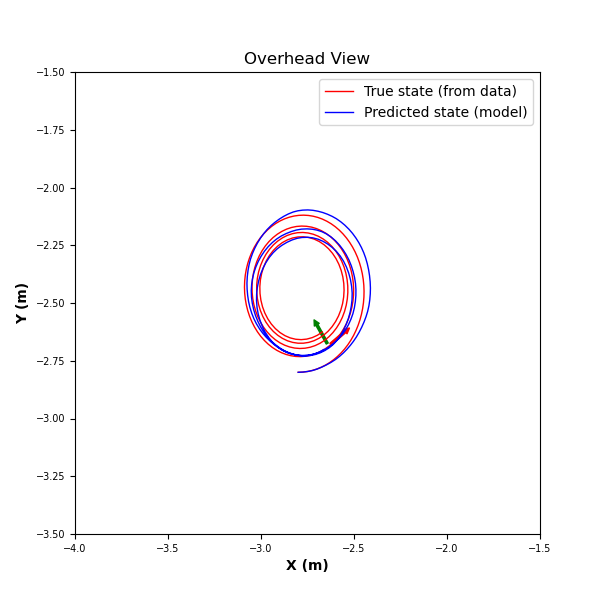

Box(children=(IntSlider(value=0, description='Frame: ', layout=Layout(flex='3 1 0%', width='auto'), max=251), …

In [3]:
# Create a robot
bot = PenguinPi(wheels_width=0.14, wheels_radius=0.01)

# Here we load our data including the control inputs and the true state 
with open('Support/data/data.dat', "rb") as f:
    data = pickle.load(f)
    
true_state = data['state'][48:,:]
control = data['control'][48:,:]

# Set the initial state of the robot from the data
init_x, init_y, init_theta = true_state[0,:]
bot.set_state(x=init_x, y=init_y, theta=init_theta)

# Set the time step of the similation
dt = 0.2
# Here we will predict the robot's state using the model 
state = np.zeros((control.shape[0],3))

# At each timestep we apply the same control that was applied to the
# real robot to our model
for c in range(control.shape[0]):
    state[c,:] = np.array(bot.get_state()) 
    drive_signal = DriveMeasurement(control[c,0],control[c,1],dt)
    bot.drive(drive_signal)

#Create a visualizer and visualize the predicted and the true state
rend = Renderer.Instance()
rend.initialize(state, true_state=true_state)


**FLUX Question (1pt)**: Why does the predicted robot state differ from the real data?

# Model Uncertainty: How?

## 1. Propagation of Uncertainty

Given the initial known position of our 1D robot ($x_t$), after each step, our uncertainty about the robot's new state is defined as follows:

<center>
$\begin{equation}
\begin{split}
& P(x_{t+1}=x_{t}+1) = 0.5, \\
& P(x_{t+1}=x_{t}+1.1) = 0.25, \\
& P(x_{t+1}=x_{t}+0.9) = 0.25. 
\end{split}
\end{equation}$
</center>

Below we show how our uncertainty about the robot's true position changes with every new step.

**Interaction**
- Observe how our uncertainty about the robot's position changes when the robot moves forward 5 steps

<IPython.core.display.Javascript object>


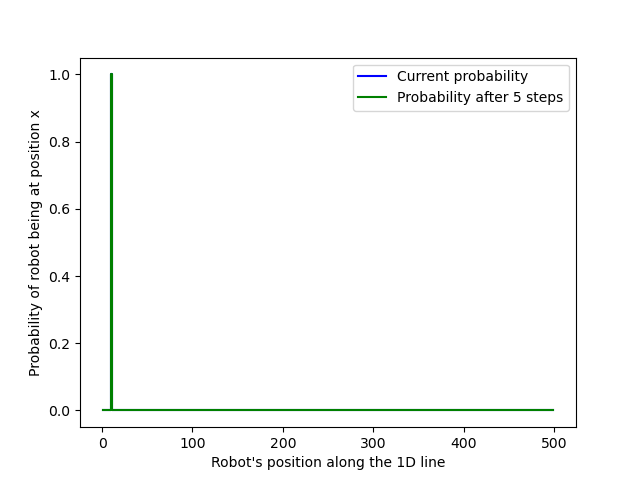

In [5]:
# We start with a known position: probability 1.0 at position 10
belief_position = Distribution.unit_pulse(10)
x, y = belief_position.plotlists(0, 500)

fig, ax = plt.subplots()
old_line, = ax.step(x, y, c='b', label='Current probability')
line, = ax.step(x, y, c='g', label='Probability after 5 steps')
ax.legend()
ax.set_xlabel("Robot's position along the 1D line")
ax.set_ylabel("Probability of robot being at position x")

def convolve_distribution(b=None):
    global belief_position
    
    # For each new control:
    # - there is 50% chance the robot moves 1m
    # - there is 25% chance the robot moves 1.1m
    # - there is 25% change the robot moves 0.9m
    
    # Plot prior belief
    old_x, old_y = belief_position.plotlists(0, 500)
    old_line.set_data(old_x, old_y)
    
    # We enconde this belief into a new distribution
    for i in range(5):
        move_distribution = Distribution.triangle(1,2)
        # We modify our belief about the robots position with a convolution
        belief_position = belief_position.convolve(move_distribution)
        new_x, new_y = belief_position.plotlists(0, 500)
        line.set_data(new_x, new_y)
        
def reset(b=None):
    global belief_position
    belief_position = Distribution.unit_pulse(10)
    x, y = belief_position.plotlists(0, 500)
    old_line.set_data(x,y)
    line.set_data(x, y)
    

btn_move = widgets.Button(description='Move 5 steps', 
                          layout=widgets.Layout(flex='1 1 0%', width='auto'),
                          button_style='success')
btn_reset = widgets.Button(description='Reset', 
                          layout=widgets.Layout(flex='1 1 0%', width='auto'),
                          button_style='success')

btn_move.on_click(convolve_distribution)
btn_reset.on_click(reset)

display(widgets.HBox([btn_move, btn_reset]))

**FLUX Question (1pt)**: After multiple steps, what does the model distribution looks like?

## 2. Reducing Uncertainty with Measurements - 1D Kalman Filter

Lets see how we can combine our model predictions and the noisy measurements from the robot's sensor in order to reduce our uncertainty about the robot's position. 

The robot model is defined as $x_{k+1} = ax_k + bu_k + \epsilon_Q, \epsilon_Q \sim \mathcal{N}(0, \sigma^2_Q)$. Similarly, we define the measurement model as $z_k = cx_k + \epsilon_R, \epsilon_R \sim \mathcal{N}(0, \sigma^2_R)$. 

### Step 1: 
We generate the true states and the noisy measurements associated to those states.

In [6]:
# 1D model parameters
u = 100 # We will drive our robot with a constant control input
a = 1
b = 1

# Number of measurements we want to generate
steps = 10

# This is our measurement constant
C = 1

#This is our true noise
true_move_noise = 2
true_mes_noise = 10

true_state, measurements = generate_measurements(steps=steps, a=a, b=b, u=u, c=C, true_move_noise=true_move_noise,
                                                true_mes_noise=true_mes_noise)

### Step 2: 
Setup and run our Kalman Filter

**TODO**:
- Complete the update state step

<IPython.core.display.Javascript object>


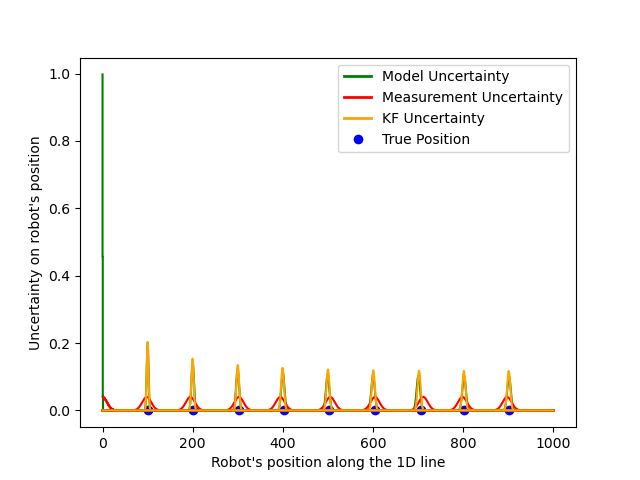

In [7]:
#----------------------------------PARAMETERS--------------------------------------
# This is our mean at t, we initialize at zero
mu_k = 0
# This is our covariance at t, we initialize very small implying we know x0 very well
sigma_k = 0.4
# This is the uncertainty in our move function 
sigma_Q = 2
# This is what we think our measurement noise is
sigma_R = 10
#-----------------------------------------------------------------------------------

# We will save our predicted state here
pred_state = np.zeros((steps,1)) 
# We will save our estimated state here
est_state = np.zeros((steps,1))

# Plotting code
x = np.linspace(0,1000,2000)
y_pred = norm.pdf(x, loc=mu_k, scale=sigma_k)
y_mes = norm.pdf(x, loc=true_state[0], scale=sigma_R)
fig, ax = plt.subplots()
mes_line, = ax.step(x, y_pred, c='g')
pred_line, = ax.step(x, y_mes, c='r')
est_line, = ax.step([],[], c='orange')
ax.set_xlabel("Robot's position along the 1D line")
ax.set_ylabel("Uncertainty on robot's position")

legend_elements = [Line2D([0], [0], color='g', lw=2, label='Model Uncertainty'),
                   Line2D([0], [0], color='r', lw=2, label='Measurement Uncertainty'),
                   Line2D([0], [0], color='orange', lw=2, label='KF Uncertainty'),
                   Line2D([0], [0], marker='o', color='w', label='True Position',
                          markerfacecolor='b', markersize=8)]

ax.legend(handles=legend_elements, loc='upper right')


for i in range(steps-1):
    
    # Prediction step
    mu_bar = a*mu_k + b*u
    sigma_bar = np.sqrt(a*a*sigma_k*sigma_k + sigma_Q*sigma_Q)  

    # Update step
    z = measurements[i+1]
    #-------------------- BJ:DONE ----------------
    # 1. Compute the Kalman Gain
    K = C*sigma_bar*sigma_bar/(C*C*sigma_bar*sigma_bar + sigma_R*sigma_R)
    
    # 2. Apply correction to mu_k
    mu_k = mu_bar + K*(z - C*mu_bar)
    
    # 3. Apply correction to sigma_k
    sigma_k = (1 - K*C)*sigma_bar
    
    #---------------------------------------------------------------#

    # Plot state distribution based on model prediction (this is our prior)
    y_pred = norm.pdf(np.array(x), loc=mu_bar, scale=sigma_bar)
    ax.plot(x,y_pred,color='green')

    # Here we compute the likelihood of the robot's position given a new measurement 
    # Note we plot the measurement centered around the true measured value
    y_mes = norm.pdf(np.array(x), loc=measurements[i+1], scale=sigma_R)
    ax.plot(x, y_mes,color='red')

    # We combine the knowledge from our model and the likelihood given our noisy measurement
    y_est = norm.pdf(np.array(x), loc=mu_k, scale=sigma_k)
    ax.plot(x, y_est,color='orange', )

    # Save our estimates
    pred_state[i+1] = mu_bar
    est_state[i+1] = mu_k
    
    time.sleep(0.5)
    fig.canvas.draw()
    
    ax.scatter(true_state[i+1], 0, color='b')

    
lb1 = widgets.Label(value='Average abs. error with measurements' + 
                    " only is {}".format(np.mean(np.abs(true_state[:-1]-measurements[:-1]))))
    
lb2 = widgets.Label(value=r'Average abs. error with Kalman Filter' + 
                    " is {}".format(np.mean(np.abs(true_state[:-1]-est_state[:-1]))))

info = widgets.VBox([lb1, lb2])
display(info)

### Interact: 

Define different ``sigma_Q`` and ``sigma_R`` values and observe their effect on the Kalman filter's estimates

**FLUX Question (1pt)**: What happens with the error between the true states and the KF estimates when our uncertainty in the model's predictions increases (take a look at the labels shown after the plot)?

## 3. Extended Kalman Filter

Lets now go back to our PenguinPi robot. We wish to have a better estimate of the PenguinPi robot's state. To do so, we will use an extended Kalman Filter (EKF). 

Using EKF, we will combine the model predictions and the measurements that our robot obtains with its camera in order to better estimate the robot's state.

For our implementation, we define the robot model as:

$\boldsymbol{x}_{k+1} = A\boldsymbol{x}_k + B\boldsymbol{u}_k + \boldsymbol{w}$, with $\boldsymbol{w} \sim \mathcal{N}(\boldsymbol{0}, \Sigma_{Q})$.

Similarly, we define the measurement model as 

$\boldsymbol{y}_{k} = C\boldsymbol{x}_k + \boldsymbol{v}$, with $\boldsymbol{v} \sim \mathcal{N}(\boldsymbol{0}, \Sigma_{R})$.

### Step 1:

Below we show the PenguinPi state when only the motion model is used to estimate the robot's state. Since we are only considering the model's prediction, we see that the robot's trajectory significantly differs from the desired trajectory.

<IPython.core.display.Javascript object>


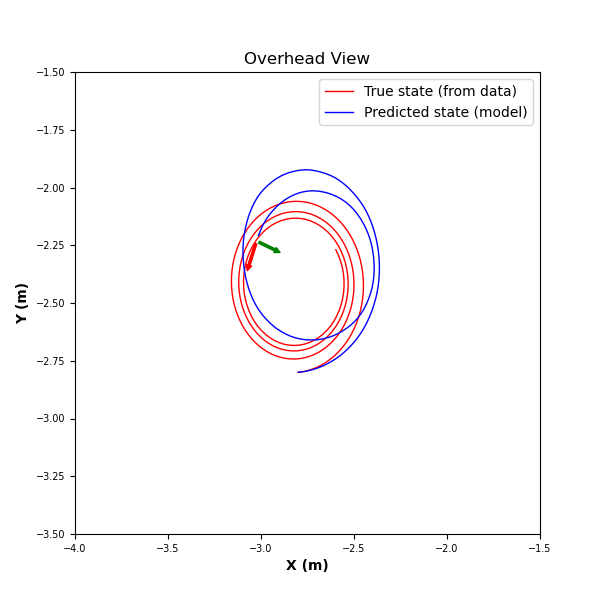

Box(children=(IntSlider(value=0, description='Frame: ', layout=Layout(flex='3 1 0%', width='auto'), max=299), …

In [8]:
#Here we load our data including the true state 
with open('Support/data/data_ekf.dat', "rb") as f:
    data = pickle.load(f)
    
gt_state = data['state']
control = data['control']
measurements = data['measurement']

#Create a robot and place it at the true starting position and orientation 
bot = PenguinPi(0.15, 0.01)
true_state = data['state']
control = data['control']

# Set the initial state of the robot from the data
init_x, init_y, init_theta = true_state[0,:]
bot.set_state(x=init_x, y=init_y, theta=init_theta)

#Apply our control to the robot and visualize
#Our timestamp is always 0.2
dt = 0.2
#Here we will save our state variable 
state = np.zeros((control.shape[0],3))

for c in range(control.shape[0]):
    state[c,:] = np.array(bot.get_state())
    drive_signal = DriveMeasurement(control[c,0],control[c,1],dt)
    bot.drive(drive_signal)

#Create a visualizer and visualize our atate
rend = Renderer.Instance()
rend.initialize(state, true_state = gt_state)

### Step 2: 

Setup and run our Extended Kalman Filter. In the plot, the yellow arrows indicate the robot's sensors.

**TODO**:
Complete the prediction step. Please keep in mind that:

- $A$ and $\Sigma_Q$ can be obtained using the functions``bot.derivative_drive(drive_signal)`` and ``bot.covariance_drive(drive_signal)`` respectively.
- $\Sigma_k$ is represented by the variable P

<IPython.core.display.Javascript object>


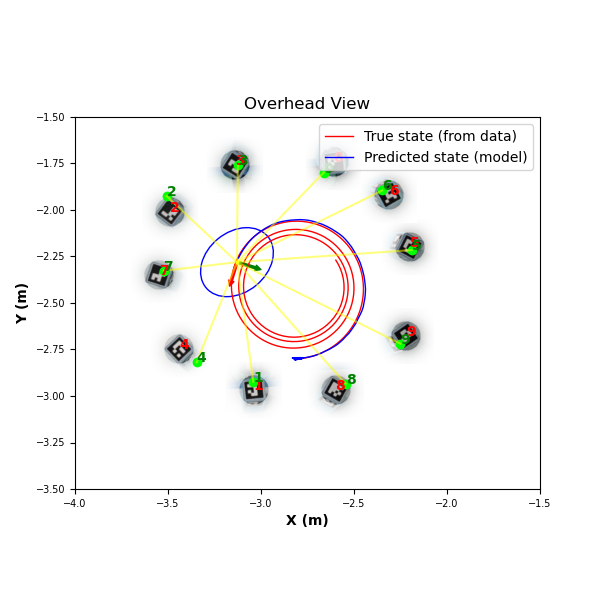

Box(children=(IntSlider(value=0, description='Frame: ', layout=Layout(flex='3 1 0%', width='auto'), max=299), …

In [9]:
# Setup our robot
bot = PenguinPi(0.14, 0.01)
true_state = data['state']
control = data['control']

# Set the initial state of the robot from the data
init_x, init_y, init_theta = true_state[0,:]
bot.set_state(x=init_x, y=init_y, theta=init_theta)

# Here are our true marker positions
markers = data['markers']

#----------------------------------PARAMETERS--------------------------------------
# Initial incertainty of our robot
P = np.eye(3)*100
# Uncertainty in our left and right wheel motors
sigma_drive = np.array([10,10])
# Uncertainty in measurement
sigma_measure = np.eye(2)*100
#-----------------------------------------------------------------------------------

# Apply our control to the robot and visualize
# Our timestamp is always 0.2
dt = 0.2
# Here we will save our state variable 
state = np.zeros((control.shape[0],3))
# Here we save the robot covariances
robot_cov = np.zeros(((control.shape[0],3,3)))

for c in range(control.shape[0]):
    # Set the measurement covariances
    for mes in measurements[c]:
        mes.covariance = sigma_measure 
    
    drive_signal = DriveMeasurement(control[c,0],control[c,1],dt,sigma_drive[0],sigma_drive[1])
    
    # Prediction Step 
    # 1. Predict state
    bot.drive(drive_signal)
    x_hat = np.array(bot.get_state()).reshape((3,1))
    #------------------------ BJ:DONE ------------------------
#     # 2. Linearize about prediction
    A = bot.derivative_drive(drive_signal)
    
#     # 3. Get covariance sigma_q
    sigma_q = bot.covariance_drive(drive_signal)
    
#     # 4. Predict robot's covariance
    P = A @ P @ A.T + sigma_q
    
    #-------------------------------------------------------
    
    # Construct measurement index list
    tags = [lm.tag for lm in measurements[c]]
    # Stack measurements and set covariance
    z = np.concatenate([lm.position.reshape(-1,1) for lm in measurements[c]], axis=0)
    R = np.zeros((2*len(measurements[c]),2*len(measurements[c])))
    for i in range(len(measurements[c])):
        R[2*i:2*i+2,2*i:2*i+2] = measurements[c][i].covariance
    
    # Update step
    
    # 1. Get location of measurements given robot's current state
    z_hat = bot.measure(markers, tags)
    z_hat = z_hat.reshape((-1,1),order="F")
        
    # 2. Linearize measurement about robot's current state
    C = bot.derivative_measure(markers, tags)
    # 3. Compute Kalman Gain
    S = C @ P @ C.T + R
    K = P @ C.T @ np.linalg.inv(S)
    # 4. Correct state
    y = z - z_hat
    x = x_hat + K @ y
    # 5. Get state estimate
    bot.set_state(x[0], x[1], x[2])
    # 6. Correct robot's covariance
    P = (np.eye(x.shape[0]) - K @ C) @ P
       
    state[c,:] = np.array(bot.get_state()).flatten()
    # Drive and predict
    robot_cov[c,:,:] = P[0:3,0:3]
    
#Create a visualizer and visualize our state
rend = Renderer.Instance()
rend.initialize(state,measurements, true_state = gt_state,robot_cov=robot_cov, add_aruco=True)

### Interact: 

Increase and decrease the uncertainty on the measurements' model ``sigma_measure``. Observe how the uncertainty about the robot's state changes.

**FLUX Question (1pt)**: How does the uncertainty on the robot's state changes when the measurements' uncertainty decreases?